# Tutorial 5

We will learn some techniques for improving the prediction scores for any chosen machine
learning models. **This will be very useful for your final project or data-science competitions.**

1. Cross validation techniques (k-fold, leave-one-out, leave-p-out)
2. Bagging
3. Ensemble

## Cross Validation
### K-Fold
Reference: https://en.wikipedia.org/wiki/Cross-validation_(statistics)

In k-fold cross-validation, the original sample is randomly partitioned into k equal 
sized subsamples. Of the k subsamples, a single subsample is retained as the validation 
data for testing the model, and the remaining $k − 1$ subsamples are used as training data. The cross-validation process is then repeated k times (the folds), with each of the k subsamples used exactly once as the validation data. The k results from the folds can then be averaged to produce a single estimation. The advantage of this method over repeated random sub-sampling is that all observations are used for both training and validation, and each observation is used for validation exactly once. 10-fold cross-validation is commonly used, but in general k remains an unfixed parameter.

![K-Fold cross validation](images/kfold.png)

** Step 1: Load data **

We will use digit dataset for all our experiments for this tutorial.

In [2]:
random_state = 2017
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

#mnist = datasets.fetch_mldata('MNIST original')
digits = datasets.load_digits()

** STEP 2: Split into training and testing **

In [5]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(digits.data, digits.target, 
                                          train_size = 0.7, 
                                          random_state=random_state)

In [6]:
X_tr.shape, X_ts.shape, Y_tr.shape, Y_ts.shape

((1257, 64), (540, 64), (1257,), (540,))

** STEP 3: Get features **

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(X_tr)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [14]:
F_tr = pca.transform(X_tr)
F_ts = pca.transform(X_ts)
F_tr.shape, F_ts.shape

((1257, 50), (540, 50))

** STEP 4: Perform K-Fold cross validation **

In [10]:
from sklearn.model_selection import KFold

k3 = KFold(n_splits=3)
gen = k3.split([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
list(gen)

[(array([4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3])),
 (array([0, 1, 2, 3, 7, 8, 9]), array([4, 5, 6])),
 (array([0, 1, 2, 3, 4, 5, 6]), array([7, 8, 9]))]

In [11]:
from keras.utils import np_utils
T_tr = np_utils.to_categorical(Y_tr, nb_classes=10)
T_ts = np_utils.to_categorical(Y_ts, nb_classes=10)

Using Theano backend.


In [12]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

def loss(probs_ts):
    """
    Using log-loss as metric for comparison
    """
    return log_loss(T_ts, probs_ts)

def accuracy(probs_ts):
    """
    Prediction accuracy
    """
    return accuracy_score(Y_ts, np_utils.probas_to_classes(probs_ts))

In [31]:
lr = LogisticRegression()
def get_prediction(n_folds=3):
    kf = KFold(n_splits=n_folds)
    probs = []
    results = []
    for tr, _ in kf.split(F_tr):
        print("Performing training on fold...")
        lr.fit(F_tr[tr], Y_tr[tr])
        p = lr.predict_proba(F_ts)
        probs.append(p)
        results.append([loss(p), accuracy(p)])
    return np.array(probs), np.array(results)

In [32]:
probs, results = get_prediction()

Performing training on fold...
Performing training on fold...
Performing training on fold...


In [46]:
import pandas as pd
cp = np.mean(probs, axis=0)
pd.DataFrame(np.vstack((results, [loss(cp), accuracy(cp)])), 
    columns=['Loss', 'Accuracy'])

,Loss,Accuracy
0,0.266906,0.955556
1,0.262609,0.948148
2,0.260650,0.951852
3,0.249289,0.961111


In [73]:
import matplotlib.pyplot as plt
from skimage.io import imread
%matplotlib inline
def success(cp, ci):
    """
    Did cross validation improved the scores?
    """
    r_com = np.mean(ci, axis=0)
    plt.figure(figsize=(6, 6))
    if r_com[0] > cp[0]:
        plt.imshow(imread('images/crval_success.jpg'))
        plt.axis('off')
    else:
        plt.imshow(imread('images/tut5_fail.png'))
        plt.axis('off')

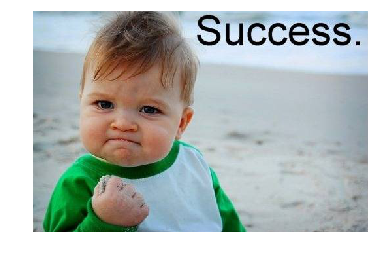

In [74]:
success([loss(cp), accuracy(cp)], results)

#### Exercise (10 minutes)
Perform the K-Fold cross validation with multiple values of K and write your observations. 

### Perform Leave-One-Out (LOO) cross validation

Reference: https://stats.stackexchange.com/questions/27454/how-does-leave-one-out-cross-validation-work-how-to-select-the-final-model-out

It is best to think of cross-validation as a way of estimating the generalization performance of models generated by a particular procedure, rather than of the model itself. Leave-one-out cross-validation is essentially an estimate of the generalization performance of a model trained on $n−1$ samples of data, which is generally a slightly pessimistic estimate of the performance of a model trained on $n$ samples.

Note however that LOOCV has a high variance (the value you will get varies a lot if you use a different random sample of data) which often makes it a bad choice of estimator for performance evaluation, even though it is approximately unbiased. I use it all the time for model selection, but really only because it is cheap (almost free for the kernel models I am working on).

In [79]:
from sklearn.model_selection import LeaveOneOut
loov = LeaveOneOut()
list(loov.split(range(1, 10)))

[(array([1, 2, 3, 4, 5, 6, 7, 8]), array([0])),
 (array([0, 2, 3, 4, 5, 6, 7, 8]), array([1])),
 (array([0, 1, 3, 4, 5, 6, 7, 8]), array([2])),
 (array([0, 1, 2, 4, 5, 6, 7, 8]), array([3])),
 (array([0, 1, 2, 3, 5, 6, 7, 8]), array([4])),
 (array([0, 1, 2, 3, 4, 6, 7, 8]), array([5])),
 (array([0, 1, 2, 3, 4, 5, 7, 8]), array([6])),
 (array([0, 1, 2, 3, 4, 5, 6, 8]), array([7])),
 (array([0, 1, 2, 3, 4, 5, 6, 7]), array([8]))]

#### Exercise (15 minutes)
- Perform the LOOCV on above digit dataset using Logistic Regression.
- Write your observations.
- How does it compare against K-Fold?
- Similarly perform `Leave P Out (LPO)` cross-validation with $p=3$.

## Bagging: Boostrap Aggregation

Reference: https://en.wikipedia.org/wiki/Bootstrap_aggregating, https://github.com/founddrama/coursera-data-analysis/blob/master/lectures/week7-lectures.Rmd

Given a standard training set D of size n, bagging generates m new training set $D_{i}$, each of size $n`$, by sampling from $D$ uniformly and with replacement. By sampling with replacement, some observations may be repeated in each $D_{i}$. If $n`$=n, then for large n the set $D_{i}$ is expected to have the fraction $(1 - \frac{1}{e})$ of the unique examples of D, the rest being duplicates. This kind of sample is known as a bootstrap sample. The $m$ models are fitted using the above $m$ bootstrap samples and combined by averaging the output (for regression) or voting (for classification).

![Bagging](images/bagging.png)

**NOTE:** For our case, we will use augmented data-set and will create 5 sample data-sets from it (called as bag individually). Will we train a predictor on each bag and average the final classification probabilities

In [115]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=3,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.0,
        zoom_range=0.1,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=False,
        vertical_flip=False,
        rescale=None)

In [116]:
I_tr = X_tr.reshape(1257, 1, 8, 8)

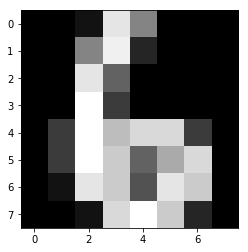

In [117]:
plt.imshow(I_tr[4][0, :, :], cmap='Greys_r')

In [118]:
igen = datagen.flow(I_tr, Y_tr, batch_size=I_tr.shape[0])
b1_x, b1_y = igen.next()
b2_x, b2_y = igen.next()
b3_x, b3_y = igen.next()
b4_x, b4_y = igen.next()
b5_x, b5_y = igen.next()

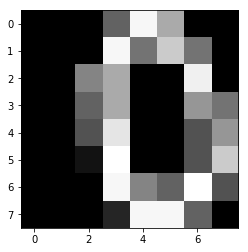

In [123]:
plt.imshow(b1_x[34][0, :, :], cmap='Greys_r')

## Exercise (20 minutes)
- Use the bagged training data and perform PCA (trained with original data set).
- Train the LR/SVM or some classifier on each bag and find classification probabilities per bag.
- Take final average of probabilities and compare it against same predictor trained against non bagged input/output data.
- You may or may not use cross-validation per bag.

## Ensemble

Reference: https://www.toptal.com/machine-learning/ensemble-methods-machine-learning

![Ensemble](images/ensemble.jpg)

Ensemble methods are techniques that create multiple models and then combine them to produce improved results. Ensemble methods usually produces more accurate solutions than a single model would. This has been the case in a number of machine learning competitions, where the winning solutions used ensemble methods. In the popular Netflix Competition, the winner used an ensemble method to implement a powerful collaborative filtering algorithm. Another example is KDD 2009 where the winner also used ensemble methods. You can also find winners who used these methods in Kaggle competitions, for example here is the interview with the winner of CrowdFlower competition.

It is important that we understand a few terminologies before we continue with this article. Throughout the article I used the term "model" to describe the output of the algorithm that trained with data. This model is then used for making predictions. This algorithm can be any machine learning algorithm such as logistic regression, decision tree, etc. These models, when used as inputs of ensemble methods, are called "base models".

![Ensemble](images/ensemble_explain.png)

## Exercise: 20 minutes

- Use PCA features to train multiple predictors and find their classification probabilities for testing data.
- Find the final averaged probabilities and find the loss and accuracy score.
- Compare loss and accuracy score against individual predictor.